In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import os
from IPython.display import display
!pip install mxnet
!pip install gluonnlp
!pip install mxnet-cu101
import mxnet as mx
from mxnet import gluon
from embedding import BertEmbedding

In [2]:
# macros
test_size = 100
learning_rate = 0.0001
raw = pd.read_csv('DJIA_table.csv').sort_values('Date').set_index('Date')

# customized RMSE loss function
def RootMeanSquaredError(y_actual, y_predict):
  mse = tf.keras.losses.MeanSquaredError()
  return tf.sqrt(mse(y_actual, y_predict))

# dataframe split function
def split_test1(embedding, test_size):
    
    embedding_test = embedding.iloc[-test_size:, :]
    embedding = embedding.iloc[:-test_size, :]
    
    return embedding_test, embedding

# array split function
def split_test2(array, spilt_day):
    return array[-spilt_day:]

# pretrained bert embedding for djia_tweet_model
def embedding(x):
  res = []
  for i in x:
    res.append(np.array(bert_embedding(i)[0][1]).sum(axis=0))
  return np.array(res)

# Define a model in GPU for faster training
ctx = mx.gpu()
bert_embedding = BertEmbedding(model='bert_12_768_12', dataset_name='book_corpus_wiki_en_cased', ctx=ctx)

In [3]:
# load and set up djia_bert_model
djia_bert_model = tf.keras.models.load_model("./djia_bert_model", compile=False)

djia_bert_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

djia_bert_model.summary()

Model: "sum_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
combined (InputLayer)           [(None, 3072)]       0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 1000)         3073000     combined[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 1000)         0           dense_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 1000)         4000        dropout_15[0][0]                 
________________________________________________________________________________

In [4]:
# 100 test data for djia_bert_model
djia = raw.loc[:, [ 'Open', 'Adj Close']]
open_price = djia[['Open']]
adj_close_price = djia[['Adj Close']]
djia.head()

combined_embedding = pd.read_json("./combined_embedding_djia.json")
display(combined_embedding.head(2))
print(combined_embedding.shape, open_price.shape, adj_close_price.shape)

combined_embedding_test, combined_embedding_train = split_test1(combined_embedding, test_size)
open_price_test, open_price_train = split_test1(open_price, test_size)
adj_close_price_test, adj_close_price_train = split_test1(adj_close_price, test_size)

print(combined_embedding_test.shape, open_price_test.shape, adj_close_price_test.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
2008-08-08,0.245311,0.064119,-0.162365,0.187195,0.056578,-0.131683,0.191607,0.314567,0.086445,-0.110991,0.190021,0.121629,-0.213989,0.399462,-0.43226,-0.098910,-0.092872,0.004749,-0.061989,-0.039188,-0.227244,-0.20868,-0.211240,-0.005511,0.302372,0.033314,0.007309,0.696421,0.062785,0.274242,0.184959,-0.134512,0.009166,0.211059,0.348480,-0.090604,0.163173,0.353846,-0.033330,-0.017881,...,-4.077493,1.764557,-1.631178,-3.903261,-3.940772,2.376117,-0.554668,4.169759,2.519159,-1.093761,1.651675,0.913639,-3.247669,-7.475955,-0.281124,0.856160,-0.180772,3.237412,-0.735969,1.872009,-0.382135,-3.345077,3.245784,-1.023563,3.256544,-3.596019,1.541400,1.79292,-0.196114,-1.178398,-2.177266,4.572645,-2.560421,-1.670261,-0.422812,2.445834,-1.815011,5.500051,1.034655,-0.752853
2008-08-11,0.218631,-0.139643,-0.293958,0.333288,0.137994,-0.204363,0.252587,0.391931,0.011296,-0.090809,0.237901,0.388639,-0.080481,0.481464,-0.26106,-0.281789,0.041407,0.006829,-0.431086,0.093590,-0.013127,0.01418,-0.117494,0.067838,0.155665,-0.331306,-0.067758,0.559213,-0.019849,0.193418,0.147936,-0.075137,0.233045,-0.000550,0.055295,-0.079152,-0.196653,0.458401,0.071302,0.013432,...,-5.079923,1.229726,5.675801,-4.592824,-1.602164,6.488589,2.297479,2.531513,2.331375,1.496962,4.106759,-1.201664,-1.941909,0.528358,2.490081,-0.539751,0.452474,-0.433924,-1.404218,5.471732,-3.297520,-0.438559,5.559334,-3.772755,7.136041,-7.438874,8.138679,-1.80691,-0.082570,-3.117792,-2.516995,5.164186,-1.565977,-8.427419,8.952234,10.241213,-4.777753,6.802305,-0.966222,-2.821915


(1989, 3072) (1989, 1) (1989, 1)
(100, 3072) (100, 1) (100, 1)


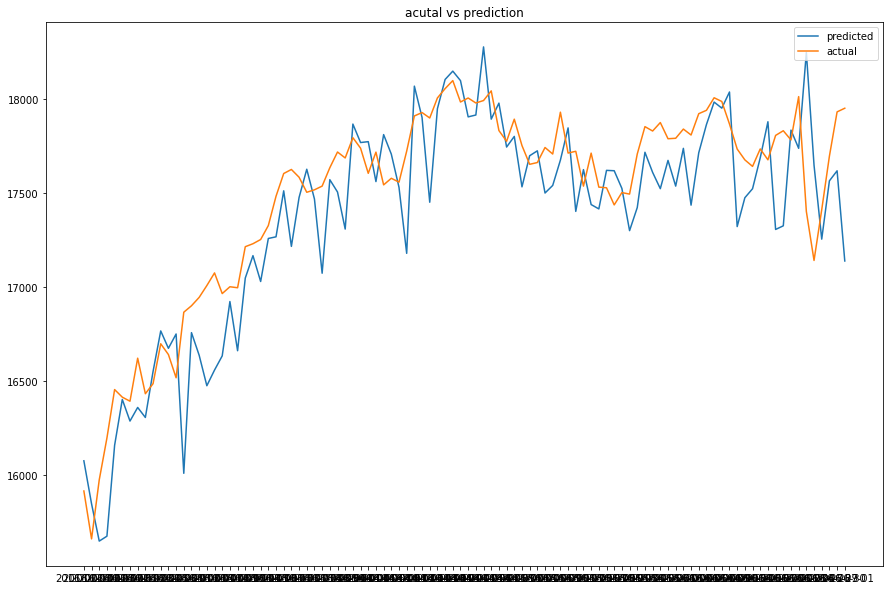

In [5]:
# prediction
bert_predicted_close_price = djia_bert_model.predict([combined_embedding_test, open_price_test])

# plot acutal vs prediction
plt.figure(figsize=(15,10))
plt.plot(bert_predicted_close_price)
plt.plot(adj_close_price_test)
plt.title('acutal vs prediction')
# plt.ylabel('predicted_close_price')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

In [6]:
# load and set up djia_lstm_model
djia_lstm_model = tf.keras.models.load_model("./djia_lstm_model", compile=False)

djia_lstm_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

djia_lstm_model.summary()

Model: "LSTM_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 60, 50)       11200       inputs[0][0]                     
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 60, 50)       0           lstm_3[0][0]                     
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 60, 50)       20200       dropout_4[0][0]                  
_________________________________________________________________________________________

In [7]:
# 100 test data for djia_lstm_model
raw_x = raw.drop(columns={'Close'})
raw_y_open = raw[['Open']]
raw_y_close = raw[['Adj Close']]

time_step = 60
total_days = len(raw_y_open)
raw_x = raw_x.values
raw_y_open = raw_y_open.values
raw_y_close = raw_y_close.values

x = []
y_open = []
y_close = []

for i in range(time_step, total_days):
  x.append(raw_x[i-60:i])
  y_open.append(raw_y_open[i])
  y_close.append(raw_y_close[i])

x = np.array(x)
y_open = np.array(y_open)
y_close = np.array(y_close)

print(x.shape, y_open.shape, y_close.shape)

x_test = split_test2(x, test_size)
y_open_test = split_test2(y_open, test_size)
y_close_test = split_test2(y_close, test_size)

print(x_test.shape, y_open_test.shape, y_close_test.shape)

(1929, 60, 5) (1929, 1) (1929, 1)
(100, 60, 5) (100, 1) (100, 1)


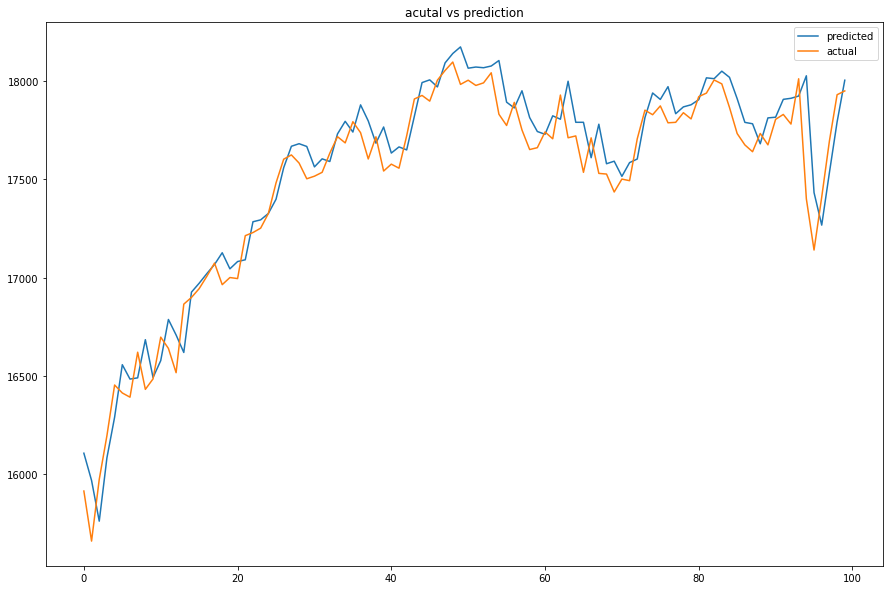

In [8]:
# prediction
lstm_predicted_close_price = djia_lstm_model.predict([x_test, y_open_test])

# plot acutal vs prediction
background = raw['Adj Close'].iloc[-100:].to_frame()
background.index = np.arange(100)
plt.figure(figsize=(15,10))
plt.plot(lstm_predicted_close_price)
plt.plot(background)
plt.title('acutal vs prediction')
# plt.ylabel('predicted_close_price')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

In [9]:
# load and set up djia_tweet_model
djia_tweet_model = tf.keras.models.load_model("./djia_tweet_model", compile=False)

djia_tweet_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

djia_tweet_model.summary()

Model: "combined_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
combined (InputLayer)           [(None, 3072)]       0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1000)         3073000     combined[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 1000)         0           dense_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 1000)         4000        dropout_3[0][0]                  
___________________________________________________________________________

In [10]:
# 100 test data for djia_tweet_model
tweet_raw = pd.read_json('./trump_tweets.json')
tweet_raw = tweet_raw[(tweet_raw['date'] >= "2016-02-10") & (tweet_raw['date'] <= "2016-07-02") & (tweet_raw['isRetweet'] == 'f')]
tweet_raw['date'] = tweet_raw['date'].dt.strftime('%Y-%m-%d')
tweet_raw = tweet_raw.sort_values('date')
tweet_raw.head(5)

temp = {}
dates = raw.index[-100:]
for index, row in tweet_raw.iterrows():
  if row['date'] in dates:
    if row['date'] in temp:
      temp[row['date']][0].append([row['text']])
    else:
      temp[row['date']] = [[[row['text']]]]

tweets = pd.DataFrame.from_dict(temp, orient='index')

# bert embedding
tweets_embedding = tweets.iloc[:, 0].apply(embedding)
tweets_embedding = tweets_embedding.to_frame()

tweets_combined_embedding = tweets_embedding[0].map(lambda x: np.concatenate((np.min(x, axis=0), np.max(x, axis=0), np.sum(x, axis=0), np.mean(x, axis=0)))).to_frame()
tweets_combined_embedding.head(5)

tweets_combined_embedding = pd.DataFrame(tweets_combined_embedding.iloc[:, 0].tolist())
tweets_combined_embedding.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,-0.712350,-2.095540,-3.032817,-1.367409,-0.632769,-1.856890,-0.712606,-1.405983,-8.039089,-6.168681,-5.353605,2.955157,-9.012931,0.812443,-7.248469,-4.802406,-5.119676,-2.211325,-2.776500,-2.212253,-5.711905,-9.116732,-5.617408,-0.802059,-4.248104,-5.691004,-2.378222,2.620466,-2.250031,1.255918,-5.037769,-6.079314,-2.619345,-2.780385,-4.899098,-0.580362,-2.236209,-2.561615,-10.970537,-1.809485,...,0.717508,0.255123,3.125003,-5.371225,-3.620856,4.205565,-0.051730,2.396321,0.807185,2.905083,5.200193,-1.262425,-2.302626,1.141079,1.158841,-1.024865,1.970136,1.272008,-1.538945,-0.213803,0.330470,-1.970760,3.999925,-0.405116,3.377092,-3.864137,0.864468,-0.993681,1.323388,-0.619285,1.002855,2.985835,-3.329303,-4.581949,-0.860276,-2.020579,0.011790,3.004468,0.963876,3.137684
1,-2.886785,-2.376335,-3.963827,-2.786152,-3.023444,-3.117975,0.280808,-1.792493,-8.513457,-4.691761,-0.758524,3.116440,-7.351190,-2.836464,-9.381563,-6.286273,-5.279817,-6.306399,-3.762503,-1.307336,-9.337859,-7.436369,-9.836844,-3.810521,-1.447158,-6.653240,-4.986041,0.294545,-6.672920,1.445718,-5.691851,-2.962914,-3.546877,-3.448585,-4.000446,-1.573712,-4.467943,-0.502461,-4.450592,-1.229823,...,-0.302629,1.194165,0.736431,-5.259173,-2.595991,3.856475,-0.795320,1.937412,1.492530,2.889216,4.537484,-1.543836,-5.653625,0.375788,0.853363,-1.126176,-0.079975,0.478480,-1.084268,1.006857,-1.637392,-3.637767,3.958554,-0.824103,4.117502,-3.937575,0.301434,-0.166363,1.339336,-0.736181,0.280277,1.771286,-3.042862,-3.827818,-2.169233,0.744264,0.421146,4.056686,1.318558,2.164151
2,-2.282661,-2.329068,-5.947567,-6.112398,-1.868654,-3.721653,-1.167469,-3.021925,-7.889187,-4.111317,-0.837985,1.812044,-6.326545,-0.216214,-13.295482,-8.196780,-4.808110,-8.317935,-8.938932,-5.188424,-9.089967,-6.137352,-7.581148,-1.826544,-3.435288,-6.668691,-5.121111,0.724683,-5.663333,1.305113,-9.039728,-4.081089,-11.256489,-5.085773,-5.139478,-2.509314,-4.910172,-0.226853,-6.368226,-3.947077,...,-1.730618,1.222568,1.432225,-4.326667,-3.657274,4.396658,-1.318514,2.504998,1.308659,1.254203,3.856408,-2.021655,-6.526807,-1.214257,1.242846,0.272338,1.349184,0.785933,-0.994707,1.836590,-1.879846,-3.733068,3.296438,-1.345130,5.069886,-4.040869,-0.536767,-0.132181,0.771578,-0.406563,-0.673236,1.288170,-1.800359,-4.028264,-1.010321,0.084339,0.042540,3.432547,1.092408,3.440923
3,-1.322931,-2.250398,-3.967192,-2.256668,-2.278296,-2.842208,1.523245,-2.700220,-11.356763,-6.534440,-1.416298,4.625303,-7.779529,1.733050,-9.207008,-5.822247,-2.718468,-7.939626,-5.990510,-1.477690,-10.220681,-9.090809,-6.208910,-1.103747,-4.010996,-5.576307,-2.216959,3.563890,-1.367673,3.361492,-7.524205,-3.740963,-5.540902,-1.638182,-3.933767,-0.103105,-1.752166,-0.391144,-7.495245,-1.751834,...,-2.113427,0.664883,2.998127,-4.874518,-4.276525,2.992499,0.617942,1.537871,-0.089437,2.142131,4.210179,-2.806896,-5.872974,-1.294909,1.980631,-2.531222,2.775673,1.237892,-1.476437,0.117570,-0.124838,-2.444124,3.631168,-0.267516,3.612885,-2.887757,0.302631,-1.667846,2.318827,-0.493025,-0.692438,3.686267,-4.617770,-6.637393,-1.427064,-2.620021,0.626343,3.070204,2.986845,5.302890
4,-1.926980,-1.276260,-8.500539,-5.489338,-1.106090,-2.243853,1.639152,-1.834610,-4.652178,-6.106426,0.508100,2.470943,-8.935768,-1.401711,-8.778233,-5.248172,-4.944563,-7.253568,-5.969954,-2.717230,-9.772478,-8.145957,-12.591365,-0.746176,-3.247822,-11.041114,-1.176402,2.128019,-4.048051,2.084043,-5.797697,-1.490711,-6.648732,-6.532199,-6.689563,-2.892877,-10.297640,-0.634005,-6.156660,-2.175711,...,-2.372450,0.366352,0.541653,-4.019486,-2.731088,3.894555,0.291877,2.767934,1.997297,1.675684,3.957261,-3.043698,-6.209980,-0.657875,1.421644,-0.178466,1.0

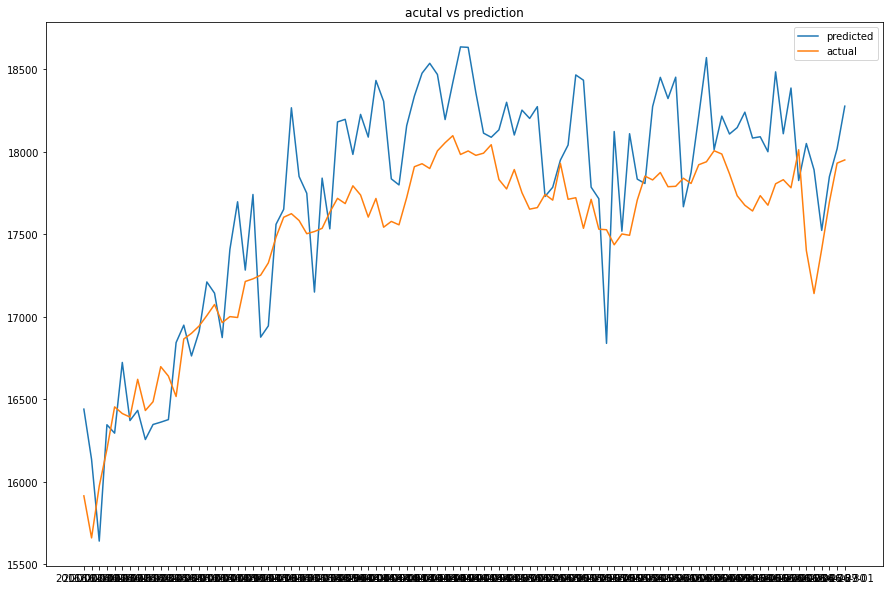

In [11]:
# prediction
tweet_predicted_close_price = djia_tweet_model.predict([tweets_combined_embedding, open_price_test])

# plot acutal vs prediction
plt.figure(figsize=(15,10))
plt.plot(tweet_predicted_close_price)
plt.plot(adj_close_price_test)
plt.title('acutal vs prediction')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

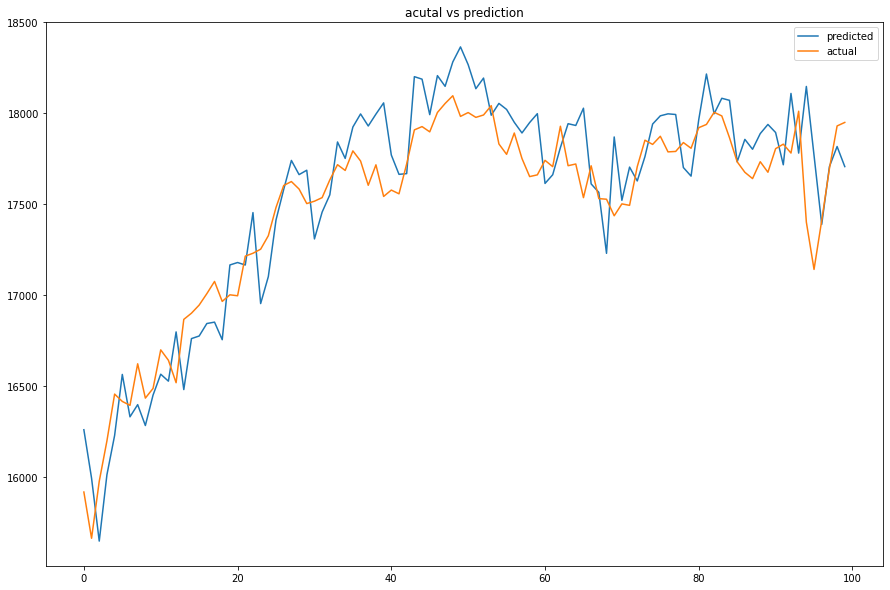

In [13]:
# ensemble prediction
ensemble_prediction = [0] * 100
for i in range(100):
  ensemble_prediction[i] = (bert_predicted_close_price[i] + lstm_predicted_close_price[i] + tweet_predicted_close_price[i]) / 3

# plot acutal vs prediction
background = raw['Adj Close'].iloc[-100:].to_frame()
background.index = np.arange(100)
plt.figure(figsize=(15,10))
plt.plot(ensemble_prediction)
plt.plot(background)
plt.title('acutal vs prediction')
# plt.ylabel('ensemble_prediction')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()